# Training Temporal Convolutional Neural Network on Landsat Satellite Image Time Series to Detect Leafy Spurge

This Notebook aims to develop a temporal convolutional neural network based on a time series of Landsat satellite imagery and class labels from the National Land Cover Dataset (NLCD). 

Table of Contents

- Introduction
- Import packages (including Tensorflow and TemporalCNN modules)
- Define paths for model inputs (data) and model outputs (evaluation metrics)
- Read Landsat SITS data and reshape to use in a Temporal CNN
- Subset data into training, testing, and validation sets
- Build the Temporal CNN model using Keras
- Define model variables (batch size, class weights, epochs, callbacks)
- Run the model!
- Evaluate and save performance metrics
- Evaluate and save confusion matrix
- TBD...


Contributors:
Thomas Lake
Ryan Briscoe Runquist

Version: November 17 2022


# Python General Packages & Imports

In [1]:
#Script uses conda environment 'tf_gpu_earthengine' from conda env 'tf_gpu'

# Packages
import sys
import os
import pandas as pd
import numpy as np
import datetime
import pprint
import time
import math
import random
from glob import glob
from functools import reduce
from pprint import pprint
import itertools
from scipy.spatial.distance import cdist

# Plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Tensorflow Imports


In [2]:
# Tensorflow setup

# Tensorflow version 2.4.1
import tensorflow as tf
print(tf.__version__) 

# Keras setup.
import keras
from keras import layers
from keras.layers import Flatten
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.regularizers import l2
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Flatten, Lambda, SpatialDropout1D, Concatenate
from keras.layers import Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint, History, EarlyStopping
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras import backend as K


2023-04-24 08:21:20.832629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


Use this chunk to check the hardware (CPU vs GPU)

In [3]:
# # Are We Using a GPU?

# import tensorflow as tf

# print(tf.config.list_physical_devices('GPU'))
# # [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# print(tf.test.is_built_with_cuda)
# # <function is_built_with_cuda at 0x7f4f5730fbf8>

# print(tf.test.gpu_device_name())
# # /device:GPU:0

# print(tf.config.get_visible_devices())
# # [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# # Matrix multiplication test with gpu

# a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
# b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
# c = tf.matmul(a, b)

# Import temporalCNN Python modules

These are a set of functions published by Pelletier et al., 2019: "Temporal convolutional neural network for the classification of satellite image time series"

https://github.com/charlotte-pel/temporalCNN/

In [4]:
import sys

# Import from ~/sits folder
# Contains readingsits.py file to read and compute and reshape the SITS data
sys.path.append("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/sits")
import readingsits

# Import from ~/deeplearning folder
# Contains multiple .py files with varying DL architectures 
sys.path.append("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/deeplearning")

import architecture_features
import architecture_complexity
import architecture_rnn
import architecture_regul
import architecture_batchsize
import architecture_depth
import architecture_spectro_temporal
import architecture_pooling

# Import from ~/outputfiles folder
# Contains evaluation.py and save.py files with fucntions to compute summary statistics, write predictions, and create confusion matrices
sys.path.append("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/outputfiles")

import evaluation
import save

# Create Model Dataset with Latitude/Longitude Coordinates Included

In [5]:
# Combine multiple CSV files with identical columns into one CSV & export

#from pathlib import Path
#import pandas as pd
#import numpy as np
#import glob

#path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22' # use your path

#all_files = glob.glob(os.path.join(path, "*.csv"))

#df0 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2001_full_dataset_oct2022.csv')
#df1 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2004_full_dataset_oct2022.csv')
#df2 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2006_full_dataset_oct2022.csv')
#df3 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2008_full_dataset_oct2022.csv')
#df4 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2011_full_dataset_oct2022.csv')
#df5 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2013_full_dataset_oct2022.csv')
#df6 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2016_full_dataset_oct2022.csv')
#df7 = pd.read_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2019_full_dataset_oct2022.csv')

#df_full = pd.DataFrame(np.concatenate((df0.values, df1.values, df2.values, df3.values, df4.values, df5.values, df6.values, df7.values), axis=0))

#df = pd.concat((pd.read_csv(f, header=None) for f in all_files), ignore_index=True)

#print(df_full.shape)

#df_full.head()

#print(df_full.dtypes)

#Write full dataframe to csv
#df_full.to_csv('/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_jan2023.csv', sep=',', header=False, index=False)


In [6]:
#from sklearn.model_selection import train_test_split

#train_df, test_df = train_test_split(df, test_size=0.1)

#Number of rows/columns in dataset
#print(train_df.shape, test_df.shape)

# Write full training and testing dataframes to CSV
# Export format as rows [classID, index, band_values/timeseries..., lat/long] with no header
#train_df.to_csv("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/train_dataset_full_latlong_jan2023.csv", header=False)
#test_df.to_csv("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/test_dataset_full_latlong_jan2023.csv", header=False)


In [7]:
# Export full dataset as csv
#df.head()
#df.to_csv('/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_jan2023.csv', sep=',', index=False)


In [8]:
#from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

# Root to data folder, a training or validation file
#data_path = "/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_jan2023.csv"

# Read in data file in pandas as csv
#df = pd.DataFrame(pd.read_csv(data_path, header=None))



# Spatial Point Thinning for Leafy Spurge Occurrences from EddMaps/GBIF/iNaturalist

Several functions read in the full NLCD Landsat dataset, subset only leafy spurge coordinates from the dataset by class (val = 9).
Then, calculate the pairwise distance between every point. Randomly remove one point of two that are within specified distance.

In [9]:
# # Read training set dataframe
# full_df = pd.DataFrame(pd.read_csv("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_jan2023.csv"))

# full_df

# import pandas as pd
# import numpy as np
# from scipy.spatial.distance import cdist

# # Select only training samples that need spatial bias correction (leafy spurge) from class = 9
# df_spurge = full_df[full_df.iloc[:, -1] == 9.0]

# #df_spurge # 51753 rows x 67 columns

# # Select the longitude and latiude coordinates from the dataframe to calculate point distances
# df_spurge_coords = df_spurge.iloc[:, [-3, -2]]

# # Calculate Euclidean distance between all leafy spurge occurrence points
# distances = cdist(df_spurge_coords, df_spurge_coords)

# # Identify in the distance matrix, where points are closer than 0.001 decimal degrees
# indices = np.where(distances <= 0.001)

# # Randomly remove one point from each pair of points that are too close
# indices_to_remove = set()
# for i, j in zip(indices[0], indices[1]):
#     if i < j:
#         indices_to_remove.add(j)
#     elif i > j:
#         indices_to_remove.add(i)

# # Drop/Thin occurrences by index
# df_spurge_thinned = df_spurge.drop(df_spurge.index[list(indices_to_remove)])

# #df_spurge_thinned # 27329 rows × 67 columns

# # subset/remove leafy spurge from the training dataset, for custom point thinning.
# df_no_spurge = full_df[full_df.iloc[:, -1] != 9.0]

# # add back only thinned spurge occurrences
# df_full_thinned_spurge = pd.concat([df_no_spurge, df_spurge_thinned])

# # In total, we removed 24,424 leafy spurge records (nearly half!) by thinning to 0.001 decimal degrees
# df_full_thinned_spurge # 6158470 x 67 columns

# #df_full_thinned_spurge.to_csv('/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_thinned_001dd_spurge_apr2023.csv', header=False, index=False)


# Set Model Paths for Input Data & Model Results Files

In [10]:
# Set a model results path
res_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN'

# Set Architecture / Model Run Index (used if running in batch on MSI)
noarchi = 4
norun = 1
feature = "SB" #use only spectral bands provided (do not compute new bands, like NDVI, which are already computed)
train_str = "latlong"

# Creating output path if does not exist
if not os.path.exists(res_path):
  print("ResPath DNE")
  os.makedirs(res_path)

# Output files			
res_path = res_path + '/Archi' + str(noarchi) + '/'
if not os.path.exists(res_path):
  os.makedirs(res_path)
  print("noarchi: ", noarchi)

# Create output files to capture model results
str_result = feature + '-' + train_str + '-noarchi' + str(noarchi) + '-norun-' + str(norun)

# Output for model evaluation metrics
res_file = res_path + 'result_accuracy_metrics-' + str_result + '.txt'

# Output for model loss / epochs
traintest_loss_file = res_path + 'trainingHistory-' + str_result + '.txt'

# Output for confusion matrix
conf_file = res_path + 'confMatrix-' + str_result + '.txt'

# Output for model weights file (.h5 file)
out_model_file = res_path + 'model-' + str_result + '.h5'

print("Model accuracy metrics: " + res_file)
print("Model history: " + traintest_loss_file)
print("Model confusion matrix: " + conf_file)
print("Model weights: " + out_model_file)


Model accuracy metrics: /panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi4/result_accuracy_metrics-SB-latlong-noarchi4-norun-1.txt
Model history: /panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi4/trainingHistory-SB-latlong-noarchi4-norun-1.txt
Model confusion matrix: /panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi4/confMatrix-SB-latlong-noarchi4-norun-1.txt
Model weights: /panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi4/model-SB-latlong-noarchi4-norun-1.h5


# Data Generator for Spectral & Positional Data
# Training Data

In [11]:
from tensorflow.keras.utils import to_categorical

# Read training set dataframe, specify header=1 to read data from row=1 and ignore the column names
train_df = pd.DataFrame(pd.read_csv("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_train_dataset_allyears_latlong_thinned_001dd_spurge_apr2023.csv", header=1))
#train_df.head()
#print(train_df.shape)
nchannels = 7 #-- B G NDVI NIR Red SWIR1 SWIR2

# Select spectral data (first 63 columns)
batch_X = train_df.iloc[:, 1:64].to_numpy()
batch_X_spectral = batch_X.reshape(batch_X.shape[0],int(batch_X.shape[1]/nchannels),nchannels)
#print(batch_X_spectral[0])
#print(batch_X_spectral.shape)

# Select latitude/longitude coordinates (get last 3 columns, remove last 1 (class) column)
batch_X_coords = train_df.iloc[:, -3:].iloc[:, :-1].to_numpy()
#print(batch_X_coords.shape)

# Add X data(lat/long coordinates and spectral data) as list to X_train
# Add Y data(class) to Y_train
X_train = [batch_X_coords, batch_X_spectral]

# Select class data from last column
y_train = np.asarray(train_df.iloc[:, -1]).astype(int)
#print(batch_Y.shape)
#print(batch_Y)
y_train_one_hot = to_categorical(y_train)
#print(Y_one_hot.shape)

print(X_train[0].shape, X_train[1].shape, y_train_one_hot.shape)



(4625162, 2) (4625162, 9, 7) (4625162, 10)


# Testing Data

In [12]:

# Read validation set dataframe
test_df = pd.DataFrame(pd.read_csv("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_test_dataset_allyears_latlong_thinned_001dd_spurge_apr2023.csv"))
#test_df.head()
#print(test_df.shape)
nchannels = 7 #-- B G NDVI NIR Red SWIR1 SWIR2

# Select spectral data (first 63 columns)
batch_X = test_df.iloc[:, 1:64].to_numpy()
batch_X_spectral = batch_X.reshape(batch_X.shape[0],int(batch_X.shape[1]/nchannels),nchannels)
#print(batch_X_spectral[0])
#print(batch_X_spectral.shape)

# Select latitude/longitude coordinates (get last 3 columns, remove last 1 (class) column)
batch_X_coords = test_df.iloc[:, -3:].iloc[:, :-1].to_numpy()
#print(batch_X_coords.shape)

# Add X data(lat/long coordinates and spectral data) as list to X_test
# Add Y data(class) to Y_test
X_test = [batch_X_coords, batch_X_spectral]

# Select class data from last column
y_test = np.asarray(test_df.iloc[:, -1]).astype(int)
#print(batch_Y.shape)
#print(batch_Y)
y_test_one_hot = to_categorical(y_test)
#print(Y_one_hot.shape)

print(X_test[0].shape, X_test[1].shape, y_test_one_hot.shape)





(592538, 2) (592538, 9, 7) (592538, 10)


# Validation Data

In [13]:

# Read validation set dataframe
valid_df = pd.DataFrame(pd.read_csv("/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_valid_dataset_allyears_latlong_thinned_001dd_spurge_apr2023.csv"))
#valid_df.head()
#print(valid_df.shape)
nchannels = 7 #-- B G NDVI NIR Red SWIR1 SWIR2

# Select spectral data (first 63 columns)
batch_X = valid_df.iloc[:, 1:64].to_numpy()
batch_X_spectral = batch_X.reshape(batch_X.shape[0],int(batch_X.shape[1]/nchannels),nchannels)
#print(batch_X_spectral[0])
#print(batch_X_spectral.shape)

# Select latitude/longitude coordinates (get last 3 columns, remove last 1 (class) column)
batch_X_coords = valid_df.iloc[:, -3:].iloc[:, :-1].to_numpy()
#print(batch_X_coords.shape)

# Add X data(lat/long coordinates and spectral data) as list to X_valid
# Add Y data(class) to Y_valid
X_valid = [batch_X_coords, batch_X_spectral]

# Select class data from last column
y_valid = np.asarray(valid_df.iloc[:, -1]).astype(int)
#print(batch_Y.shape)
#print(batch_Y)
y_valid_one_hot = to_categorical(y_valid)
#print(Y_one_hot.shape)

print(X_valid[0].shape, X_valid[1].shape, y_valid_one_hot.shape)


(702867, 2) (702867, 9, 7) (702867, 10)


# Define Temporal CNN Model Components


In [ ]:

#Build the Temporal CNN 
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input

#Get model input sizes
input_shape = (9, 7) #spectral data dimensions (batch size, timesteps, channels)
input_coords_shape = (2,) #lat long coords (batch size, [lat, long])

# Model 1
    # Latitude/Longitude Spatial Encoding
    # Define Input for Spatial Data
X_coords_input = Input(shape=(input_coords_shape))
    #-- lat long coordinates fc + relu
model1_out = Dense(576, activation='relu')(X_coords_input) #Dense 576 = 9 (timesteps) * 64 (conv1d filters)
model1 = Model(inputs = [X_coords_input],  outputs = [model1_out])

# Model 2
    # Temporal Convolutional Neural Network (1D-CNN)
#-- parameters of the architecture
nbclasses = 10 # number of classes for output
l2_rate = 1.e-6 # regularization
dropout_rate = 0.1 # regularization
nbunits_conv = 64 #-- convolution filters, will be double
nbunits_fc = 128 #-- fully connected (dense) layer, will be double    
    
	# Define the input placeholders.
X_input = Input(input_shape) # (batch size, timesteps, channels)
    #-- Conv BN Activation Dropout
X = Conv1D(filters = 64, kernel_size = 3, strides = 1, dilation_rate=1, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(X_input)
X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X) 
X = Conv1D(filters = 64, kernel_size = 3, strides = 1, dilation_rate=2, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(X)
X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = Conv1D(filters = 128, kernel_size = 3, strides = 1, dilation_rate=4, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(X)
X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
model2_out = Flatten()(X)
model2 = Model(inputs = [X_input], outputs = [model2_out])

# Combine two models on common axis 576
concatenated = Concatenate(axis=-1)([model1_out, model2_out])

# Model 3 (combined model)
    # Fully connected layer and softmax output
Z = Dense(nbunits_fc, kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(concatenated)
Z = BatchNormalization(axis=-1)(Z)
Z = Activation('relu')(Z)
Z = Dropout(dropout_rate)(Z, training=True) #adding training = True to dropout allows us to use dropout during training and inference (for uncertainty)
	#-- SOFTMAX layer
out = Dense(nbclasses, activation='softmax', kernel_initializer="he_normal",kernel_regularizer=l2(l2_rate))(Z)

# Create merged model.
merged_model = Model(inputs = [X_coords_input, X_input], outputs = out)


# Create the Deep Learning Model in Keras

Before we create the model, there's still a wee bit of pre-processing to get the data into the right input shape and a format that can be used with cross-entropy loss. Specifically, Keras expects a list of inputs and a one-hot vector for the class. (See the Keras loss function docs, the TensorFlow categorical identity docs and the tf.one_hot docs for details).

Here we will use a simple neural network model with a 64 node hidden layer, a dropout layer and an output layer. Once the dataset has been prepared, define the model, compile it, fit it to the training data. See the Keras Sequential model guide for more details.

In [ ]:

#Define Class Weights
from sklearn.utils import class_weight

class_weights =  class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)

class_weights = dict(zip(np.unique(y_train), class_weights))

print(class_weights)



In [ ]:

# Class weights function
# proportional to class frequency
class_weights = {0: 0,
                 1: 1.046028630719989,
                 2: 1.6421837069230087,
                 3: 1.37461158722999,
                 4: 0.7614511317372198,
                 5: 0.6015453322153169,
                 6: 0.3652990948014909,
                 7: 0.39487324200412083,
                 8: 4.334510403657227,
                 9: 13}



# Set Model variables
n_epochs = 100
batch_size = 10192
lr = 0.0001 # initial learning rate for optimizer (see below: learning rate scheduler for warmup and cosine decay)
beta_1 = 0.9 #learning rate at home 
beta_2 = 0.98 #not sure what this parameter does
epsilon = 1e-07 #a variable. see learning rate scheduler.

#Model Optimizer (adam)
opt = tf.keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

# Set Loss function 
cce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile Model
merged_model.compile(optimizer = opt, loss = cce, metrics = ["accuracy"])

merged_model.summary()

# Model callbacks: Checkpoint, Early Stopping, Plot Losses (interactively)

In [ ]:

# Save Model at Regular Checkpoints
checkpoint = ModelCheckpoint(out_model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1, mode='auto', restore_best_weights=False)

#Plot Loss and Accuracy Callback
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.f1 = []
        self.val_f1 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.f1.append(logs.get('accuracy'))
        self.val_f1.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val loss")
        ax1.legend()
        
        ax2.plot(self.x, self.f1, label="Acc")
        ax2.plot(self.x, self.val_f1, label="val Acc ")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

class LROutput(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(lr)
        
lr_output = LROutput()


# Model Callback: Warmup Learning Rate

In [ ]:

def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))


   
# Number of training samples (rows).
sample_count = X_train[0].shape[0]

# Total epochs to train.
epochs = n_epochs

# Number of warmup epochs. (10% of total epochs)
warmup_epoch = 10

# Training batch size, set small value here for demonstration purpose.
batch_size = batch_size

# Base learning rate after warmup.
learning_rate_base = 0.001

total_steps = int(epochs * sample_count / batch_size) #98,275

# Compute the number of warmup batches.
warmup_steps = int(warmup_epoch * sample_count / batch_size) #9827

# Compute the number of warmup batches.
warmup_batches = warmup_epoch * sample_count / batch_size

# Create the Learning rate scheduler.
warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                        total_steps=total_steps,
                                        warmup_learning_rate=0.0,
                                        warmup_steps=warmup_steps,
                                        hold_base_rate_steps=0)


# Model Training

In [ ]:
#Train the model
start_train_time = time.time()

# Fit the model
hist = merged_model.fit(x = X_train, 
                 y = y_train_one_hot, 
                 epochs = 100,
                 batch_size = batch_size,
                 validation_data = (X_valid, y_valid_one_hot),
                 shuffle=True,
                 verbose=1,
                 class_weight = class_weights,
                 callbacks = [warm_up_lr, plot_losses])


train_time = round(time.time()-start_train_time, 2)


# Save the trained model

In [ ]:

# Save the Trained Model as a .h5 file
merged_model.save(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi4/TemporalCNN_100epochs_latlongenc_spatialthin001dd_classweightfreq_uncertainty_apr122023-1.h5')
           


# Load a trained model

In [14]:

# Load a trained model
model = keras.models.load_model(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/TemporalCNN_100epochs_latlongenc_dropout_uncertainty_topmodel_apr122023.h5')

model.summary()

2023-04-24 08:29:02.675258: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-24 08:29:02.677162: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-24 08:29:02.677199: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-24 08:29:02.677249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cn0029): /proc/driver/nvidia/version does not exist
2023-04-24 08:29:02.677642: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 9, 7)]       0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 9, 32)        704         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 9, 32)        128         conv1d_9[0][0]                   
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 9, 32)        0           batch_normalization_12[0][0]     
___________________________________________________________________________________________

# Evaluate model losses and accuracy and save outputs

In [15]:
# Evaluate the model prediction

from sklearn.metrics import multilabel_confusion_matrix
from tabulate import tabulate

# Predict the model on withheld testing dataset
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=-1)
y_pred_flat = y_pred.flatten()
y_pred_flat = y_pred_flat.astype(int)

y_test = y_test.astype(int)    
y_test_flat = y_test.flatten()

#Count number of classes in the testing dataset
unique_vals, counts = np.unique(y_test, return_counts=True)

# Calculate confusion matrix
class_names = ["Water", "Developed", "BarrenLand", "Forest", "Shrub/Scrub", "Grassland/Herbaceous", "Croplands", "EmergentWetlands", "LeafySpurge"]
class_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
c = multilabel_confusion_matrix(y_test_flat, y_pred_flat, labels = class_labels)
model_output_metrics = []
for i in range(len(class_labels)):
    tn=c[i, 0, 0]
    tp=c[i, 1, 1]
    fn=c[i, 1, 0]
    fp=c[i, 0, 1]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    TPR_Sens_Recall = tp/(tp+fn)
    TNR_Spec = tn/(tn+fp)
    FPR = fp/(fp+tn)
    FNR = fn/(fn+tp)
    precision = tp/(tp+fp)
    jaccard = tp/(tp+fp+fn)
    beta = 0.5
    F05 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    beta = 1
    F1 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    beta = 2
    F2 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    outputs = [class_names[i], counts[i], tp, tn, fp, fn, accuracy, TPR_Sens_Recall, TNR_Spec, FPR, FNR, precision, jaccard, F2]
    model_output_metrics.append(outputs)

# Print and format outputs
print(tabulate(model_output_metrics, floatfmt=".2f", headers=["Class Name", "Num Points", "TP", "TN", "FP", "FN", "Accuracy", "TPR/Sens/Recall", "TNR/Spec", "FPR", "FNR", "Precision", "Jaccard", "F2"]))

#Save model results to file
with open(res_file, 'w') as f:
    f.write(tabulate(model_output_metrics, floatfmt=".2f", headers=["Class Name", "TP", "TN", "FP", "FN", "Accuracy", "TPR/Sens/Recall", "TNR/Spec", "FPR", "FNR", "Precision", "Jaccard", "F1"]))
    

# Save losses and accuracy
train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']
train_acc  = hist.history['accuracy']
val_acc    = hist.history['val_accuracy']
xc         = range(n_epochs)

len(train_loss)
len(val_loss)
len(train_acc)
len(val_acc)
len(xc)

traintest_loss_df = pd.DataFrame(
    {'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'epochs': xc
    })

traintest_loss_df
    
#np.savetxt(traintest_loss_file, traintest_loss_df, fmt='%6f')



2023-04-24 08:29:11.681845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-24 08:29:11.682974: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2497165000 Hz


Class Name              Num Points         TP         TN        FP        FN    Accuracy    TPR/Sens/Recall    TNR/Spec    FPR    FNR    Precision    Jaccard    F2
--------------------  ------------  ---------  ---------  --------  --------  ----------  -----------------  ----------  -----  -----  -----------  ---------  ----
Water                     15160.00   13641.00  576908.00    470.00   1519.00        1.00               0.90        1.00   0.00   0.10         0.97       0.87  0.91
Developed                 20549.00   12807.00  556781.00  15208.00   7742.00        0.96               0.62        0.97   0.03   0.38         0.46       0.36  0.58
BarrenLand                  680.00     209.00  591566.00    292.00    471.00        1.00               0.31        1.00   0.00   0.69         0.42       0.22  0.32
Forest                   108371.00   95519.00  472798.00  11369.00  12852.00        0.96               0.88        0.98   0.02   0.12         0.89       0.80  0.88
Shrub/Scrub     

1803

NameError: name 'hist' is not defined

# Calculate confusion matrix for model and save outputs

In [ ]:

import os
import sys
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.io import imread, imshow, imsave
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, jaccard_score, fbeta_score
from tensorflow.keras.models import load_model
from tabulate import tabulate

def plot_confusion_matrix(
        y_true,
        y_pred,
        classes,
        test_name,
        normalize=False,
        set_title=False,
        save_fig=False,
        cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if set_title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    # and save it to log file
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        #with open(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_log.txt', 'ab') as f:
        #    f.write(b'\nNormalized confusion matrix\n')
        #    np.savetxt(f, cm, fmt='%.3f')
    else:
        print('Confusion matrix, without normalization')
        #with open(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_log.txt', 'ab') as f:
        #    f.write(b'\nConfusion matrix, without normalization\n')
        #    np.savetxt(f, cm, fmt='%7u')

    #print(cm)
    #cm = cm[1:10]
    #cm = cm[:,1:]

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if normalize:
        im.set_clim(0., 1.)     # fixes missing '1.0' tick at top of colorbar
    cb = ax.figure.colorbar(im, ax=ax)
    if normalize:
        cb.set_ticks(np.arange(0., 1.2, 0.2))
        cb.set_ticklabels([f'{i/5:.1f}' for i in range(6)])
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title if set_title else None,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(cm)-0.5, -0.5)
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(10)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if np.round(cm[i, j], 2) > 0.:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
            else:
                ax.text(j, i, '–',
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    if save_fig:
        if normalize:
            plt.savefig(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_cm_normal.pdf')
        else:
            plt.savefig(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_cm_non_normal.pdf')
    return fig, ax, cm




inv_category_dict = {1:"Water", 2:"Developed", 3:"BarrenLand", 4:"Forest", 5:"Shrub/Scrub", 6:"Grassland/Herbaceous", 7:"Croplands", 8:"EmergentWetlands", 9:"LeafySpurge"}

class_names = [inv_category_dict[i] for i in np.arange(1, 10)]


# save plot of normalized cm
cm = plot_confusion_matrix(
    y_test_flat,
    y_pred_flat,
    classes=class_names,
    test_name="myModel",
    normalize=True,
    save_fig=False
)

conf_df = pd.DataFrame(cm[2], columns = ["Water", "Developed", "BarrenLand", "Forest", "Shrub/Scrub", "Grassland/Herbaceous", "Croplands", "EmergentWetlands", "LeafySpurge"])

#np.savetxt(conf_file, conf_df, fmt='%6f')


# Predict a .tif image using a model with latitude/longitude and spectral data

For exporting only the leafy spurge softmax layer, replace 'dst.write(pim3, 1)' with 'dst.write(pim[:, :, 9], 1)' below.

In [ ]:

#Model Prediction on small TIF raster file

import rasterio as rio
from rasterio.plot import show
import glob
import time
import itertools

# Input prediction .tif path
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/'

# Output prediction file path
outpath = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions/'

# List all .tif files in /rasters folder for prediction
tif_image_list = glob.glob(image_path + '*.tif')

print(tif_image_list[0])

# Loop through every tif file for prediction.
for t in range(len(tif_image_list)):
    
    prediction_train_time = time.time()
    
    with rio.open(tif_image_list[t], 'r') as dataset:
        # First, get the coordinates of every pixel in the .tif image
        # Define shape of .tif image
        shape = dataset.shape
        nodata = dataset.nodata
        
        #Get the X,Y coordinates (lat/long) for each dataset (image) and index as np array
        xy1, xy2 = tee(dataset.xy(x, y) for x, y in np.ndindex(shape))  # save re-running dataset.xy
        data = ((x, y, z[0]) for (x, y), z in zip(xy1, dataset.sample(xy2)) if z[0] != nodata)
        res = pd.DataFrame(data, columns=["lon", "lat", "data"])
        coords = res.to_numpy() #convert to numpy array
        coords2 = coords[:,0:2] # Remove 'data' column, make latitude come before longitude
        coords2[:,[1,0]] = coords2[:,[0,1]] # swap longitude and latitude columns
        #print(coords2[1:10, :], coords2.shape)
        print("Got Coordinates of Landsat Image \n")
        
        # Second, get the spectral data from every pixel in the .tif image
        arr = dataset.read()
        # Define shape of input .tif image
        bands, width, height = arr.shape

        # Convert Tif Data Type to float32 by division.
        arr = arr/10000

        # Reshape .tif array axes for correct format so model can predict.
        arr = np.moveaxis(arr, 0, -1) #move axis to channels last
        new_arr = arr.reshape(-1, arr.shape[-1]) #reshape to row and column
        num_pixels = width*height
        spectral = new_arr.reshape(num_pixels, 9, 7)
        print(spectral.shape)

        #combine both latitude/longitude and spectral data into list for model prediction
        X_pred = [coords2, spectral]
        print("Got Spectral Data\n")

        # Predict model and reshape to export.
        p = model.predict(X_pred) # p is prediction from the DL model
        pim = p.reshape(width, height, 10) # Dimension of prediction in rows, columns, bands (10 classes)
        pim2 = np.moveaxis(pim, 2, 0) # move axis so bands is first

           
        # ArgMax for Segmentation.
        pim3 = np.argmax(pim2, axis=0) # take softmax of predictions for segmentation
        print(pim3.shape)

        # Get the file name (landsat_image_170_t.tif) by splitting input path.
        fileout_string = os.path.split(tif_image_list[t])

        # Output prediction raster .
        out_meta = dataset.meta.copy()

        # Get Output metadata.
        out_meta.update({'driver':'GTiff',
                         'width':dataset.shape[1],
                         'height':dataset.shape[0],
                         'count':1,
                         'dtype':'float64',
                         'crs':dataset.crs, 
                         'transform':dataset.transform,
                         'nodata':0})

        # Write predicted raster to file.
        with rio.open(fp=outpath + "/prediction_" + fileout_string[-1], #outputpath_name
                     mode='w',**out_meta) as dst:
                     dst.write(pim3, 1) # the numer one is the number of bands
        #dst.write(pim[:, :, 9], 1) to export one layer, write individual bands
        print("Writing file... \n")
        prediction_time = round(time.time()-prediction_train_time, 2)
        print(prediction_time)
    


In [17]:
import rasterio as rio

# Predict a .tif image using a model with latitude/longitude and spectral data

# Exporting Softmax Prediction of Each Class, With Mean and Stdev of 5 Predictions for Uncertainty

In [25]:

from itertools import tee
import glob

# Input prediction .tif path
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/'

# Output prediction file path
outpath = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/'

# List all .tif files in /rasters folder for prediction
tif_image_list = glob.glob(image_path + '*.tif')

print(tif_image_list)

#record how long a prediction takes
prediction_train_time = time.time()

# Loop through every tif file for prediction.
for t in range(len(tif_image_list)):
    with rio.open(tif_image_list[0], 'r') as dataset:
        # First, get the coordinates of every pixel in the .tif image
        # Define shape of .tif image
        shape = dataset.shape
        nodata = dataset.nodata

        coords_get_time = time.time()

        #Get the X,Y coordinates (lat/long) for each dataset (image) and index as np array
        xy1, xy2 = tee(dataset.xy(x, y) for x, y in np.ndindex(shape))  # save re-running dataset.xy
        data = ((x, y, z[0]) for (x, y), z in zip(xy1, dataset.sample(xy2)) if z[0] != nodata)
        res = pd.DataFrame(data, columns=["lon", "lat", "data"])
        coords = res.to_numpy() #convert to numpy array
        coords2 = coords[:,0:2] # Remove 'data' column, make latitude come before longitude
        coords2[:,[1,0]] = coords2[:,[0,1]] # swap longitude and latitude columns

        print("Got Coordinates of Landsat Image \n")
        coords_time = round(time.time()-coords_get_time, 2)
        print("Seconds to Calculate Coordinates:", coords_time)


        # Second, get the spectral data from every pixel in the .tif image
        arr = dataset.read()
        # Define shape of input .tif image
        bands, width, height = arr.shape

        # Convert Tif Data Type to float32 by division.
        arr = arr/10000

        # Reshape .tif array axes for correct format so model can predict.
        arr = np.moveaxis(arr, 0, -1) #move axis to channels last
        new_arr = arr.reshape(-1, arr.shape[-1]) #reshape to row and column
        num_pixels = width*height
        spectral = new_arr.reshape(num_pixels, 9, 7)
        #print(spectral.shape)

        #combine both latitude/longitude and spectral data into list for model prediction
        X_pred = [coords2, spectral]
        print("Got Spectral Data\n")

        predictions_get_time = time.time()

        #Prediction 1
        p_1 = model.predict(X_pred) # p is prediction from the model, yields (nrow * ncol, 10 classes)
        pim_1 = p_1.reshape(width, height, 10) # Dimension of prediction is now (nrow, ncol, 10 classes)
        pim_1 = np.moveaxis(pim_1, 2, 0) # move axis so classes/bands is first, dimensions now (10, nrow, ncol)

        print("Prediction 1 Completed")
        prediction_time = round(time.time()-predictions_get_time, 2)
        print("Seconds to Prediction 1:", prediction_time)

        #print(pim_1.shape)

        #Prediction 2
        p_2 = model.predict(X_pred) # p is prediction from the model, yields (nrow * ncol, 10 classes)
        pim_2 = p_2.reshape(width, height, 10) # Dimension of prediction is now (nrow, ncol, 10 classes)
        pim_2 = np.moveaxis(pim_2, 2, 0) # move axis so classes/bands is first, dimensions now (10, nrow, ncol)

        print("Prediction 2 Completed")
        prediction_time = round(time.time()-predictions_get_time, 2)
        print("Seconds to Prediction 2:", prediction_time)        

        #print(pim_2.shape)

        #Prediction 3
        p_3 = model.predict(X_pred) # p is prediction from the model, yields (nrow * ncol, 10 classes)
        pim_3 = p_3.reshape(width, height, 10) # Dimension of prediction is now (nrow, ncol, 10 classes)
        pim_3 = np.moveaxis(pim_3, 2, 0) # move axis so classes/bands is first, dimensions now (10, nrow, ncol)

        print("Prediction 3 Completed")
        prediction_time = round(time.time()-predictions_get_time, 2)
        print("Seconds to Prediction 3:", prediction_time)

        #print(pim_3.shape)

        #Prediction 4
        p_4 = model.predict(X_pred) # p is prediction from the model, yields (nrow * ncol, 10 classes)
        pim_4 = p_4.reshape(width, height, 10) # Dimension of prediction is now (nrow, ncol, 10 classes)
        pim_4 = np.moveaxis(pim_4, 2, 0) # move axis so classes/bands is first, dimensions now (10, nrow, ncol)

        print("Prediction 4 Completed")
        prediction_time = round(time.time()-predictions_get_time, 2)
        print("Seconds to Prediction 4:", prediction_time)

        #print(pim_4.shape)

        #Prediction 5
        p_5 = model.predict(X_pred) # p is prediction from the model, yields (nrow * ncol, 10 classes)
        pim_5 = p_5.reshape(width, height, 10) # Dimension of prediction is now (nrow, ncol, 10 classes)
        pim_5 = np.moveaxis(pim_5, 2, 0) # move axis so classes/bands is first, dimensions now (10, nrow, ncol)

        print("Prediction 5 Completed")
        prediction_time = round(time.time()-predictions_get_time, 2)
        print("Seconds to Prediction 5:", prediction_time)

        #print(pim_5.shape)

        # Calculate mean and standard deviation for each class
        class_means = np.mean(np.array([pim_1, pim_2, pim_3, pim_4, pim_5]), axis=0) # average predicted value across class axis 0
        class_stds = np.std(np.array([pim_1, pim_2, pim_3, pim_4, pim_5]), axis=0) # standard deviation of predicted value across class axis 0
        #class_cvs = np.array(class_stds / class_means) # coefficient of variation of predicted value across class axis 

        # Get the file name (landsat_image_170_t.tif) by splitting input path.
        fileout_string = os.path.split(tif_image_list[t])

        # Output prediction raster .
        out_meta = dataset.meta.copy()

        # Get Output metadata.
        out_meta.update({'driver':'GTiff',
                         'width':dataset.shape[1],
                         'height':dataset.shape[0],
                         'count':class_means.shape[0],
                         'dtype':'uint16',
                         'crs':dataset.crs, 
                         'transform':dataset.transform})


        # Scale the class_means array to integers between 0 and 65535
        scaled_class_means = (class_means * 65535).astype(np.uint16)

        # Write the mean array to a multiband raster file
        with rio.Env(CHECK_DISK_FREE_SPACE=False):
            with rio.open(fp=outpath + "/mean_prediction_softmax_classes_uint16_" + fileout_string[-1], mode='w',**out_meta) as dst:
                dst.write(scaled_class_means)


        # Scale the class_cvs array to integers between 0 and 255
        # To scale the integer values back to the 0-1 scale, you can simply divide the integer values by 65535 to get floating-point values between 0 and 1. float_data = int_data / 255.0
        scaled_class_stds = (class_stds * 65535).astype(np.uint16)

        # Write the stdev array to a multiband raster file
        with rio.Env(CHECK_DISK_FREE_SPACE=False):
            with rio.open(fp=outpath + "/coefvar_prediction_softmax_classes_uint16_" + fileout_string[-1], mode='w',**out_meta) as dst:
                dst.write(scaled_class_stds)

        print("Writing files... \n")
        prediction_time = round(time.time()-prediction_train_time, 2)
        print("Total Time: ", prediction_time)               


['/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_1986_tile_125_tiny_.tif', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_1989_tile_125_tiny_.tif', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_1992_tile_125_tiny_.tif', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_1995_tile_125_tiny_.tif', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_1998_tile_125_tiny_.tif', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_2001_tile_125_tiny_.tif', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/l

KeyboardInterrupt: 

# Time Series Analyses of Leafy Spurge with Linear Regression

Perform a linear regression on the pixel values over time to estimate the slope of the trendline, which indicates the overall direction and rate of change over time. Linear regression models the relationship between two variables by fitting a straight line through the data points. In the case of change detection, the independent variable is time, and the dependent variable is the pixel value. The slope of the fitted line represents the rate of change over time. A positive slope indicates an increase in the pixel value, while a negative slope indicates a decrease.

In [ ]:

#Time series analyses of each pixel in stacked rasters

import rasterio as rio
from rasterio.plot import show
import glob
import time
import itertools

# Input prediction .tif path
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny'

# Output prediction file path
outpath = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/change.tif'

# List all .tif files in /rasters folder for prediction, in chronological order
#tif_image_list = glob.glob(image_path + 'mean_*.tif')

tif_image_list = ['/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_1986_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_1989_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_1992_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_1995_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_1998_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_2001_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_2004_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_2007_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_2010_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_2014_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_2016_tile_125_tiny_.tif',
                 '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_predictions_tiny/mean_prediction_softmax_classes_landsat_image_temporalcnn_2019_tile_125_tiny_.tif']

# Load the 12 time-series rasters, only select band 9 (leafy spurge)
rasters = []
for i in range(len(tif_image_list)):
    with rio.open(tif_image_list[i], 'r') as src:
        ls_band = src.read(10)
        rasters.append(ls_band)

# Fit a linear regression model to the pixel values over time
slope_coefs = []
slope = np.zeros_like(rasters[0])
intercept = np.zeros_like(rasters[0])
r_squared = np.zeros_like(rasters[0])
for y in range(rasters[0].shape[0]):
    for x in range(rasters[0].shape[1]):
        pixel_values = [r[y, x] for r in rasters]
        coef = np.polyfit(range(len(pixel_values)), pixel_values, 1) #linear model
        slope_coefs.append(coef[0])
        slope[y, x] = coef[0]
        intercept[y, x] = coef[1]
        #residuals = pixel_values - np.polyval(coef, range(len(pixel_values)))
        #ss_res = np.sum(residuals ** 2)
        #ss_tot = np.sum((pixel_values - np.mean(pixel_values)) ** 2)
        #r_squared[y, x] = 1 - (ss_res / ss_tot)
    

# Create a new .tif file for the slope raster
with rio.open(outpath, 'w', driver='GTiff', height=slope.shape[0], width=slope.shape[1], count=1, dtype=slope.dtype, crs=src.crs, transform=src.transform) as dst:
    dst.write(slope, 1)

    

# Select and Plot linear regressions for pixel with largest positive slope, largest negative slope, and largest intercept values


In [ ]:

# find the index of the maximum and minimum absolute value
max_idx = np.argmax(np.abs(slope))
min_idx = np.argmin(slope)

# convert the index to row and column coordinates
max_row, max_col = np.unravel_index(max_idx, slope.shape)
min_row, min_col = np.unravel_index(min_idx, slope.shape)

# get the actual value of the maximum absolute value
max_val = slope[max_row, max_col]
min_val = slope[min_row, min_col]

print(max_row, max_col)
print(max_val)

print(min_row, min_col)
print(min_val)



In [ ]:


# find the largest postive intercept value
max_int_idx = np.argmax(np.abs(intercept))

# convert the index to row and column coordinates
max_row_int, max_col_int = np.unravel_index(max_int_idx, slope.shape)

# get the actual value of the maximum absolute value
max_val_int = slope[max_row_int, max_col_int]

print(max_row_int, max_col_int)
print(max_val_int)


'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/analysesNotebooks'

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Predicted Leafy Spurge (0-1) ')

Text(0.5, 1.0, 'Linear Model of Leafy Spurge ~ Time')

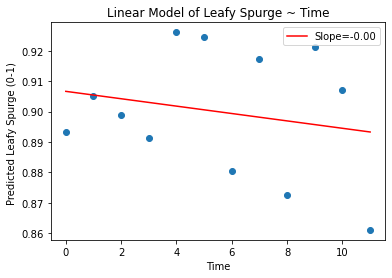

In [46]:
import matplotlib.pyplot as plt

# Choose a pixel
y, x = 73, 107 #

os.getcwd()
# 

# Get the pixel values
pixel_values = [rasters[i][y, x] for i in range(len(rasters))]

# Fit a linear regression model
coef = np.polyfit(range(len(pixel_values)), pixel_values, 1)
slope = coef[0]

# Plot the scatterplot and the fitted line
plt.scatter(range(len(pixel_values)), pixel_values)
plt.plot(np.polyval(coef, range(len(pixel_values))), color='red', label=f'Slope={slope:.2f}')
plt.xlabel('Time')
plt.ylabel('Predicted Leafy Spurge (0-1) ')
plt.title(f'Linear Model of Leafy Spurge ~ Time')
plt.legend()


plt.savefig('leafy_spurge_yampa_highflat_slope_highint_timeseries.png', dpi=300)

plt.show()



Text(0.5, 1.0, 'Panel 1')

Text(0.5, 1.0, 'Panel 2')

Text(0.5, 1.0, 'Panel 3')

Text(0.5, 1.0, 'Panel 4')

Text(0.5, 1.0, 'Panel 5')

Text(0.5, 1.0, 'Panel 6')

Text(0.5, 1.0, 'Panel 4')

Text(0.5, 1.0, 'Panel 5')

Text(0.5, 1.0, 'Panel 6')

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

Text(0.5, 0.98, 'Nine Panels')

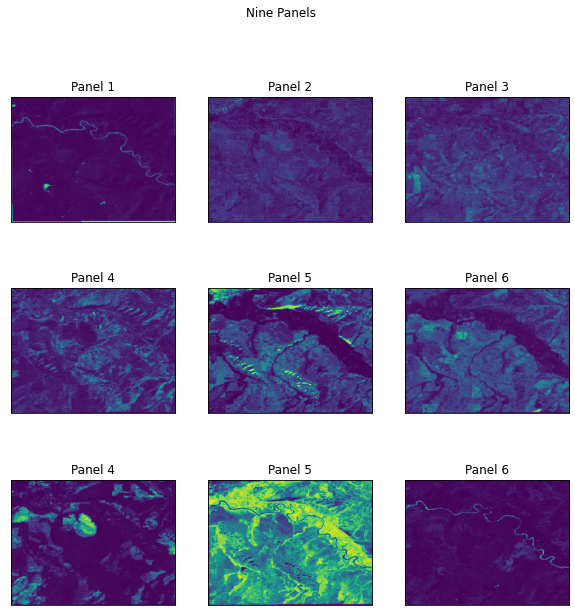

<Figure size 432x288 with 0 Axes>

In [45]:

#Plotting 
import matplotlib.pyplot as plt

# create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# show the third band of pim_5
axs[0, 0].imshow(class_means[1, ...])
axs[0, 0].set_title('Panel 1')

axs[0, 1].imshow(class_means[2, ...])
axs[0, 1].set_title('Panel 2')

axs[0, 2].imshow(class_means[3, ...])
axs[0, 2].set_title('Panel 3')

axs[1, 0].imshow(class_means[4, ...])
axs[1, 0].set_title('Panel 4')

axs[1, 1].imshow(class_means[5, ...])
axs[1, 1].set_title('Panel 5')

axs[1, 2].imshow(class_means[6, ...])
axs[1, 2].set_title('Panel 6')

axs[2, 0].imshow(class_means[7, ...])
axs[2, 0].set_title('Panel 4')

axs[2, 1].imshow(class_means[8, ...])
axs[2, 1].set_title('Panel 5')

axs[2, 2].imshow(class_means[9, ...])
axs[2, 2].set_title('Panel 6')

# remove axis labels for all subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# add overall title
plt.suptitle('Nine Panels')

plt.show()





(63, 3715, 3712)

(3715, 3712, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


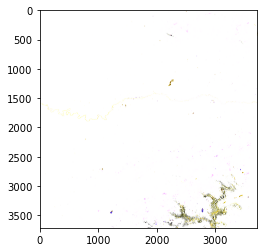

In [18]:

#Plot Landsat Imagery by Tiles and Band RGB Composites

import rasterio
import matplotlib.pyplot as plt

image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1992_tile_125_.tif'

# Load the multiband image using rasterio
with rasterio.open(image_path) as src:
    # Read the image as a numpy array
    img_array = src.read()
    img_array.shape

    # Convert the image to a three band RGB composite
    rgb = img_array[11:14, :, :].transpose(1, 2, 0)
    rgb.shape

# Display the RGB composite using matplotlib
plt.imshow(rgb)
plt.show()


#plt.savefig('leafy_spurge_softmax_predictions_2019.png', dpi=300)



(3715, 3712, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


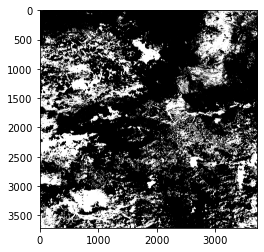

<Figure size 432x288 with 0 Axes>

# Other Helpful Functions


# Clip raster by shapefile



In [ ]:

import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask    
    
    
    
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1986_tile_125_.tif'

output_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries_tiny/landsat_image_temporalcnn_1986_tile_125_tiny_.tif'

# Open the raster file and read its metadata
with rasterio.open(image_path) as src:
    meta = src.meta

# Open the shapefile
shp = gpd.read_file(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/shapefiles/small_bbox_tile125.shp') #Shapefile must be in EPSG 4326

# Extract the geometry of the shapefile
geom = shp.geometry

# Clip the raster using the shapefile
with rasterio.open(image_path) as src:
    out_image, out_transform = mask(src, geom, crop=True)

# Update the metadata of the clipped raster
meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform})

# Write the clipped raster to a new file
with rasterio.open(output_path, "w", **meta) as dst:
    dst.write(out_image)

    
    

# Reproject Landsat/.TIF raster based on new ESPG

In [ ]:

import rasterio
from rasterio.warp import calculate_default_transform, reproject

image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1989_tile_125_.tif'

output_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile125_timeseries/landsat_image_temporalcnn_1989_tile_125_reproj_.tif'


# Open the source raster file
with rasterio.open(image_path) as src:
    print(src.crs)
    # Define the target CRS
    dst_crs = 'EPSG:3857'
    # Define the dimensions and resolution of the output raster
    dst_transform, dst_width, dst_height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    dst_profile = src.profile.copy()
    dst_profile.update({'crs': dst_crs, 'transform': dst_transform, 'width': dst_width, 'height': dst_height})
    # Reproject the raster file
    with rasterio.open(output_path, 'w', **dst_profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=rasterio.warp.Resampling.bilinear,
                num_threads=4
            )


            